# Twitter Bot

## Credentials

In [1]:
BEARER_TOKEN = "Put your app's bearer token here"

## Importing Tweepy and Authentication

In [2]:
!pip install tweepy

import tweepy
import logging

# Create logs for Tweepy

logger = logging.getLogger("tweepy")
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler(filename="tweepy.log")
logger.addHandler(handler)

# You can authenticate as your app with just your bearer token
client = tweepy.Client(BEARER_TOKEN)

     |████████████████████████████████| 77 kB 3.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Load dataset and retrieve tweets

In [106]:
import pandas as pd

df = pd.read_csv("data_repo.csv") # Labeled dataset (manually)

n_tweets = len(df['Tweet ID'])  
div = n_tweets//100      
ttexts = []
tids = []
miss = []

# Retrieve existing tweets 

for i in range(div):   
    tweet_ids = df['Tweet ID'][(i*100): (i + 1)*100]  
    response = client.get_tweets(list(tweet_ids), tweet_fields=['id', 'text', 'entities', 'lang'])
    response = response.data
    ttext = [tweet.text for tweet in response]
    tid = [tweet.id for tweet in response]
    ttexts.extend(ttext)
    tids.extend(tid)

for i in range(len(df['Tweet ID'])):
    if df['Tweet ID'][i] in tids:
        miss.append(df['is_misinfo'][i])

# Final Dataset 

dataset = pd.DataFrame(data = [tids, ttexts, miss]).transpose()
dataset.columns=['Tweet ID', 'Tweet', 'Misinforms']
display(dataset)

1523014528379670528
1523014528379670528


,Tweet ID,Tweet,Misinforms
0,1523014528379670528,oye ya pero si los #antivacuna no quieren vacu...,0
1,1523011912383881221,#Plandemia \n#LaVerdadEsUnaSola \n#AndaControl...,0
2,1523010676981387265,"@DENTRO_MADRID Si te gusta el bozal ponte 8, p...",1
3,1523009890868133894,@TAKER14719844 Nadie cree en dios\n por eso di...,0
4,1523007201844989954,@BegonaYarza basta de #DictaduraSanitaria nadi...,0
...,...,...,...
494,1522346116041392129,@eluniversocom NUNCA olvidaremos cómo @CapiZap...,0
495,1522345884498857985,"Tomemos conciencia, investiguemos, critiquemos...",1
496,1522343651673886721,"Hasta el Dr 🤡PayaZIN lo dice...\n""Algo está pa...",1
497,1522343275553861632,@lenantesur Qué rabia más grande! Y estupidez ...,0


## Tokenization of Tweets

In [107]:
from string import punctuation
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

def tweet_tokenization(sentence):

    # Remove punctuation and delete stopwords
    
    sentence = re.sub(r'http\S+', '', sentence)   # Remove URLs
    words = tokenizer.tokenize(sentence)   # Tokenization
    words = [char.lower() for char in words]  # Convert to lowercase
    new_words = [char for char in words if char not in punctuation]   # Remove punctuation
    new_words = [char for char in new_words if char not in stop]     # Remove stopwords
    sep_ = ' '.join(new_words)

    return new_words, sep_

stop = stopwords.words('spanish')
tokenizer = TweetTokenizer()
all_words = []
sep_words = []

for sentence in ttexts:
    new_words, sep_ = tweet_tokenization(sentence)
    sep_words.append(sep_)  
    all_words.extend(new_words)   # Store the resulting words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Cloud

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


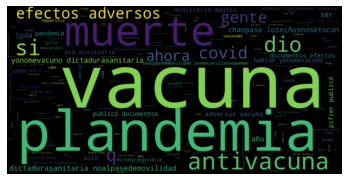

In [108]:
all_words = " ".join([word for word in all_words])  # Create a single string with all the words (for word cloud)

!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600, height=800).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("test_wc.png")  # Save word cloud
plt.show()

## Training

Accuracy: 73.0%


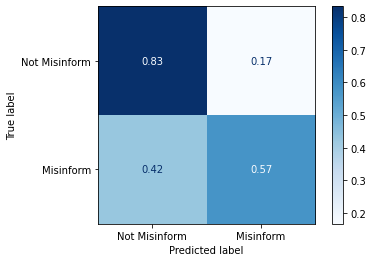

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import numpy as np

# Splitting 

X_train,X_test,y_train,y_test = train_test_split(sep_words, list(dataset.Misinforms), test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

# Vectorization of text corpus

tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Model 

model = PassiveAggressiveClassifier(max_iter=1000)
model.fit(tfidf_train, y_train)

# Prediction and Accuracy

prediction = model.predict(tfidf_test)
score = accuracy_score(y_test, prediction)
print(f'Accuracy: {round(score*100,2)}%')

# Confusion Matrix 

from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(y_test, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Misinform', 'Misinform'])
disp.plot(cmap='Blues')
plt.savefig("./confusion_matrix.png")
plt.show()



## Testing with new data

In [118]:
query = '(#DictaduraSanitaria OR cubrecobas OR vacuna OR antivacuna) lang:es -is:retweet'  # Search term

# get max. 10 tweets
tweets = client.search_recent_tweets(query=query, 
                                    tweet_fields=['text', 'entities', 'lang', 'public_metrics', 'context_annotations'],
                                    max_results=10)

tweets = tweets.data

# Retrieve information for the tweets 

ttext = [tweet.text for tweet in tweets]  
thash = []
for tweet in tweets:
    if tweet.entities is not None:
        if 'hashtags' in tweet.entities:
            th = []
            for hashtag in tweet.entities['hashtags']:
                th.append(hashtag['tag'])
            thash.append(th)

# Tokenization

sep_words = []
for text in ttext:
    _, sep_ = tweet_tokenization(text)
    sep_words.append(sep_)  

sep_words = tfidf_vectorizer.transform(sep_words)
pred = model.predict(sep_words)

# Dataframe for visualization

df = pd.DataFrame(data = [ttext, thash, pred]).transpose()
df.columns=['Tweets', 'Hashtags', 'Misinforms']
display(df)

# Export to csv
df.to_csv(r'./tweets_predict.csv', index = False)


,Tweets,Hashtags,Misinforms
0,@arturoayala_3 Sunedu no sanciono a la Univers...,None,0
1,@RamonPuig14 @gonza_30584 @ActivaDecision @man...,None,1
2,@LuisFerVillegas @HomeroLaraI @CansinoBio Todo...,None,1
3,@elgeminis1 @ActivaDecision @gonza_30584 @manu...,None,0
4,Vacuna Covid: expertos evalúan si habrá un sol...,None,0
5,no hay nadda bbue eno n las kkaku uñnas\nhttps...,None,0
6,@manuperez2002 Tengo 29 años. Adsolutamente sa...,None,0
7,¿Cómo la vacuna incide en las secuelas de la c...,None,0
8,@Li_dia_al_temps @gonza_30584 @ActivaDecision ...,None,1
9,@lximenezsarro @FreddyOliviery Gracias Doctora...,None,0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03dd7231-e080-4e18-acc7-64c1091faf30' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>